# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第27节 狗股选股策略与择时策略的配合</b></font>
</center>

-----------------


作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

上一节示例了周期均值回复短线择时策略，本节的内容将讲解选股策略与择时策略相互配合的示例。

择时与选股操作是交易系统中两大重点，它们之间的关系是相辅相成的，比如上一节实现的AbuFactorBuyWD策略本质上属于均值回复策略，因为它的买入前提是昨天下跌，今天开盘继续下跌，但是明天是周期内统计上涨概率最大的‘星期几’，量化交易本质上在策略中要做事情只有一个**制造非均衡交易环境**，目的就是为了达到**最终非均衡结果赢的钱比输的多**，择时策略和选股策略都是为了这一目标在努力，不同的择时策略应该搭配上适合的选股策略来达到1+1>2的目标，只有将选股和择时配合好，并且彻底理解你的策略，最终才能有好的结果。

首先导入本节需要使用的abupy中的模块： 

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFactorSellNDay, AbuFactorBuyWD, AbuPickStockNTop
from abupy import AbuFactorBuyBreak, AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuWeekMonthBuy
from abupy import abu, AbuFactorCloseAtrNStop, ABuProgress, AbuMetricsBase, EMarketTargetType

### 1. 狗股理论进行选股

狗股理论是美国基金经理迈克尔·奥希金斯于1991年提出的一种投资策略。

>投资股票是为了获取回报，纸上富贵固然令人热血沸腾，但现金收入才是实实在在的回报。现金收入来自哪里？可以是公司分红，也可以是卖出股票后获得的差价，即股息和资本利得。
公司股息取决于经营状况，如果业绩稳定，分红政策稳定，那么就可以有稳定的现金回报。股价虽然最终取决于公司经营状况，但在很多情况下会发生背离，在市场火爆时股价被捧上天，在市场低迷时又被打入谷底，所以与股息回报相比，资本利得的稳定性不高，不易把握。


只所以被称作狗股理论是因为将股票比做骨头，将股息比喻为骨头上的肉，狗会先吃肉最多的骨头。

![](./image/gg.jpg)

狗股策略具体的做法是，投资者每年年底从道琼斯工业平均指数成份股中找出10只股息率最高的股票，第二年买入这10支股票，一年后再找出10只股息率最高的成分股，卖出手中不在名单中的股票，买入新上榜单的股票，每年年初年底都重复这一投资动作，便可获取超过大盘的回报。

下面首先延用周期突破策略做为买入因子，卖出策略也还是继续延用，先回测未使用狗骨选股策略的情况，如下：

买入后卖出的交易数量:120
买入后尚未卖出的交易数量:8
胜率:48.3333%
平均获利期望:15.4975%
平均亏损期望:-6.3393%
盈亏比:2.0275
策略收益: 43.5203%
基准收益: 15.0841%
策略年化收益: 21.7601%
基准年化收益: 7.5420%
策略买入成交比例:66.4062%
策略资金利用率比例:38.0034%
策略共执行504个交易日


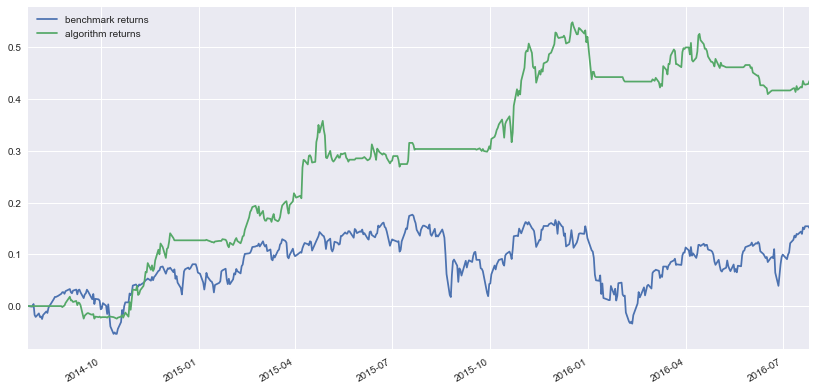

In [3]:
cash = 3000000
# 延用周期突破策略做为买入因子
buy_factors = [{'xd': 21, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]
# 卖出策略也还是继续延用
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

def run_loo_back(choice_symbols, ps=None, n_folds=2, start=None, end=None, only_info=False):
    """封装一个回测函数"""
    if choice_symbols[0].startswith('us'):
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
    else:
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
    abu_result_tuple, _ = abu.run_loop_back(cash,
                                           buy_factors,
                                           sell_factors,
                                           ps,
                                           start=start,
                                           end=end,
                                           n_folds=n_folds,
                                           choice_symbols=choice_symbols)
    ABuProgress.clear_output()
    AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=only_info, 
                                only_info=only_info,
                                only_show_returns=True)
    return abu_result_tuple

# 使用沙盒内的美股做为回测目标
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 
                     'usGOOG', 'usWUBA', 'usVIPS']
_ = run_loo_back(us_choice_symbols)

狗股理论使用的是参考值为股息率，很多基于狗股理论的选股策略进行了基因变种，如使用PEG替换股息率进行选股，或者直接使用上一年度的涨幅值做为选股参数，基于基本面数据进行选股的示例将在之后的章节进行示例，本节首先基于涨幅值做为狗股选股的参数。

abupy中内置的选股因子AbuPickStockNTop即是在选股周期上对多只股票涨跌幅进行排序，选取top n个股票做为交易目标，如下示例使用AbuPickStockNTop在选股周期内选择涨幅最大的top3做为交易目标，如下：

买入后卖出的交易数量:44
买入后尚未卖出的交易数量:3
胜率:54.5455%
平均获利期望:18.3162%
平均亏损期望:-8.0148%
盈亏比:2.1985
策略收益: 33.4785%
基准收益: 15.0841%
策略年化收益: 16.7392%
基准年化收益: 7.5420%
策略买入成交比例:97.8723%
策略资金利用率比例:23.3310%
策略共执行504个交易日


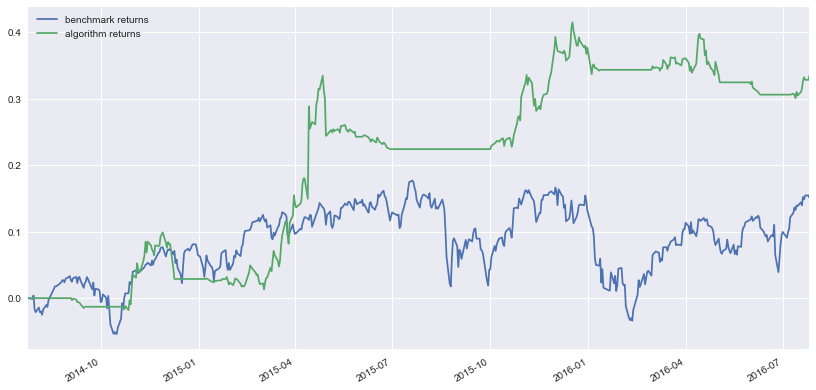

In [4]:
stock_pickers = [{'class': AbuPickStockNTop,
                  'symbol_pool': us_choice_symbols, 'n_top': 3}]
abu_result_tuple = run_loo_back(us_choice_symbols, stock_pickers)

结果如上所示，下面从交易单中可以看到整个择时周期内策略只对三支股票进行了择时：

In [5]:
set(abu_result_tuple.orders_pd.symbol)

{'usBIDU', 'usVIPS', 'usWUBA'}

上面虽然也达到了选股的目的，但是整个择时周期内只运行了一次选股策略，即只完成了静态选股，后面的择时周期内很有可能随着时间的推进，选股目标发生了变化，为了解决这个问题，可以将选股策略序列做为择时因子策略的一个参数进行构造，如下所示，这样选股策略即做为择时策略的一个专属因子，它默认在择时周期内每一个月都会重新进行一次选股策略，即完成了动态选股（也可以设置参数改变周期），使用如下所示：

买入后卖出的交易数量:51
买入后尚未卖出的交易数量:3
胜率:45.0980%
平均获利期望:13.2671%
平均亏损期望:-5.3456%
盈亏比:1.4457
策略收益: 9.2532%
基准收益: 15.0841%
策略年化收益: 4.6266%
基准年化收益: 7.5420%
策略买入成交比例:90.7407%
策略资金利用率比例:24.1769%
策略共执行504个交易日


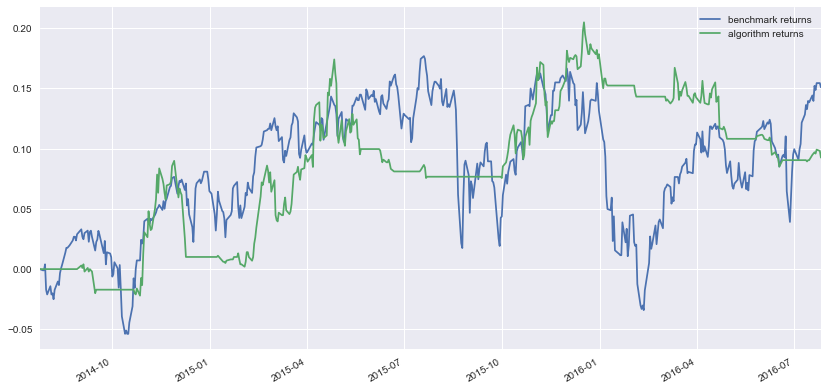

In [6]:
buy_factors = [{'xd': 21, 'class': AbuFactorBuyBreak, 'stock_pickers': stock_pickers},
               {'xd': 42, 'class': AbuFactorBuyBreak, 'stock_pickers': stock_pickers}]
abu_result_tuple = run_loo_back(us_choice_symbols)

结果如上所示，下面从交易单中可以看到整个择时周期内策略对多支股票进行了择时，并非只有3支：

In [7]:
set(abu_result_tuple.orders_pd.symbol)

{'usAAPL', 'usBIDU', 'usGOOG', 'usNOAH', 'usTSLA', 'usVIPS', 'usWUBA'}

下面更进一步打印出择时周期内每一个月的择时交易目标，可以看到每一个月最多的交易目标数量是3个，即这个月选股结果的3个交易目标都发生了突破的情况，如下所示：

In [8]:
orders_pd = abu_result_tuple.orders_pd
date_ind = orders_pd.index

def print_month_trade(base_year, range_month):
    month_fmt = lambda year, mt: '{}-0{}-01'.format(
        year, mt) if mt < 10 else '{}-{}-01'.format(year, mt)
    for month in range_month:
        if month < 12:
            next_month = month + 1
            trade_year = base_year
        else:
            next_month = 1
            trade_year = base_year + 1 
        print('{}-{}月选股交易品种{}'.format(trade_year, month, 
                                       set(orders_pd[(date_ind > month_fmt(trade_year, month)) & 
                                                     (date_ind < month_fmt(trade_year, next_month))].symbol)))
        
print_month_trade(2014, np.arange(9, 13))
print_month_trade(2015, np.arange(1, 13))
print_month_trade(2016, np.arange(1, 8))

2014-9月选股交易品种{'usTSLA'}
2014-10月选股交易品种{'usWUBA', 'usBIDU', 'usVIPS'}
2014-11月选股交易品种{'usWUBA', 'usTSLA'}
2015-12月选股交易品种set()
2015-1月选股交易品种{'usVIPS', 'usAAPL'}
2015-2月选股交易品种{'usNOAH', 'usVIPS', 'usAAPL'}
2015-3月选股交易品种{'usVIPS'}
2015-4月选股交易品种{'usBIDU', 'usNOAH', 'usAAPL'}
2015-5月选股交易品种{'usNOAH'}
2015-6月选股交易品种{'usWUBA'}
2015-7月选股交易品种{'usAAPL'}
2015-8月选股交易品种set()
2015-9月选股交易品种set()
2015-10月选股交易品种{'usWUBA', 'usNOAH', 'usAAPL'}
2015-11月选股交易品种{'usWUBA', 'usNOAH', 'usGOOG'}
2016-12月选股交易品种set()
2016-1月选股交易品种set()
2016-2月选股交易品种{'usGOOG'}
2016-3月选股交易品种{'usWUBA', 'usNOAH', 'usGOOG'}
2016-4月选股交易品种{'usTSLA', 'usGOOG'}
2016-5月选股交易品种{'usGOOG'}
2016-6月选股交易品种{'usTSLA'}
2016-7月选股交易品种{'usNOAH', 'usGOOG'}


上面的选股策略分别使用静态和动态两种模式实现，有些类似静态市盈率和动态市盈率的计算。

### 2. 选股策略与择时策略的配合

本节的重点是讲解择时策略和选股策略的配合，达到1+1>2的目标，首先你要彻底理解你的策略，上面示例的狗骨策略选取的是正向涨幅最大的top支股票，为配合这个选股结果最简单的择时策略可以是每一个月进行一次买入操作，买入上一个月涨幅最高的top支股票，持有一个月后卖出，是一个趋势跟踪的策略：

买入后卖出的交易数量:69
买入后尚未卖出的交易数量:3
胜率:43.4783%
平均获利期望:10.1924%
平均亏损期望:-6.9516%
盈亏比:1.0265
策略收益: 2.5299%
基准收益: 15.0841%
策略年化收益: 1.2649%
基准年化收益: 7.5420%
策略买入成交比例:98.6111%
策略资金利用率比例:41.6250%
策略共执行504个交易日


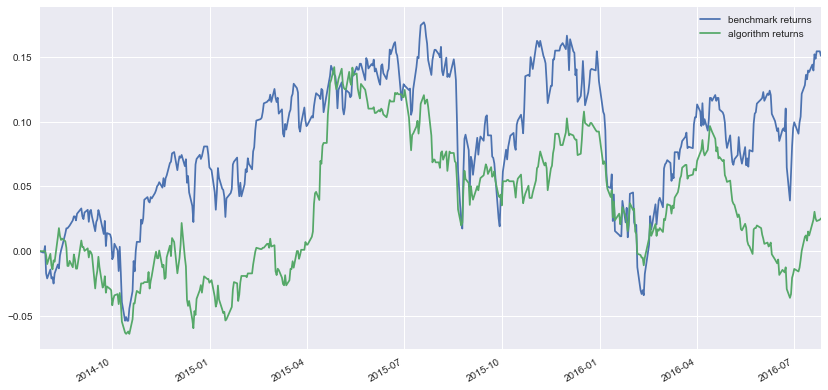

In [9]:
"""
    构建选股策略使用AbuPickStockNTop，n_top=3, 注意参数xd=20, 
    即选股分析周期为20天(选股目标为上一个月涨幅最高的3支股票)
"""
stock_pickers = [{'class': AbuPickStockNTop,
                  'symbol_pool': us_choice_symbols, 'n_top': 3, 'xd': 20}]
"""
    买入因子AbuWeekMonthBuy参数is_buy_month=True在月末买入，
    stock_pickers做为买入因子的专属选股因子进行动态选股
"""
buy_factors = [{'class': AbuWeekMonthBuy, 'is_buy_month': True, 
                'stock_pickers': stock_pickers}]
"""卖出因子使用AbuFactorSellNDay，sell_n=20, 即针对买入的股票持有20个交易日（一个月）后卖出"""
sell_factors = [{'class': AbuFactorSellNDay, 'sell_n': 20, 'is_sell_today': True}]
# 开始回测
abu_result_tuple = run_loo_back(us_choice_symbols)

针对美股市场的回测如上所示，下面输出交易单可以看到每一个月在月底都买入了3支股票，持有一个月后卖出操作，如下：

In [10]:
pd.options.display.max_rows = 21
abu_result_tuple.orders_pd.filter(['symbol', 'buy_date', 'buy_factor', 
                                   'sell_date', 'sell_type_extra', 'profit'])[:21]

,symbol,buy_date,buy_factor,sell_date,sell_type_extra,profit
2014-07-31,usSFUN,20140731,AbuWeekMonthBuy,20140828,AbuFactorSellNDay:sell_n=20,-4248.59
2014-07-31,usNOAH,20140731,AbuWeekMonthBuy,20140828,AbuFactorSellNDay:sell_n=20,-16351.96
2014-07-31,usBIDU,20140731,AbuWeekMonthBuy,20140828,AbuFactorSellNDay:sell_n=20,-12555.76
2014-08-29,usTSLA,20140829,AbuWeekMonthBuy,20140929,AbuFactorSellNDay:sell_n=20,-55032.88
2014-08-29,usBIDU,20140829,AbuWeekMonthBuy,20140929,AbuFactorSellNDay:sell_n=20,15915.36
2014-08-29,usAAPL,20140829,AbuWeekMonthBuy,20140929,AbuFactorSellNDay:sell_n=20,-11074.23
2014-09-30,usBIDU,20140930,AbuWeekMonthBuy,20141028,AbuFactorSellNDay:sell_n=20,15721.42
2014-09-30,usGOOG,20140930,AbuWeekMonthBuy,20141028,AbuFactorSellNDay:sell_n=20,-32323.05
2014-09-30,usAAPL,20140930,AbuWeekMonthBuy,20141028,AbuFactorSellNDay:sell_n=20,28030.95
2014-10-31,usVIPS,20141031,AbuWeekMonthBuy,20141201,AbuFactorSellNDay:sell_n=20,-7422.98


下面将市场切换到沙盒数据中的A股以相同的选股，择时策略进行回测，如下：

买入后卖出的交易数量:72
买入后尚未卖出的交易数量:3
胜率:54.1667%
平均获利期望:12.0454%
平均亏损期望:-8.2560%
盈亏比:1.7769
策略收益: 25.1469%
基准收益: -20.1295%
策略年化收益: 12.5735%
基准年化收益: -10.0648%
策略买入成交比例:89.3333%
策略资金利用率比例:43.8296%
策略共执行504个交易日


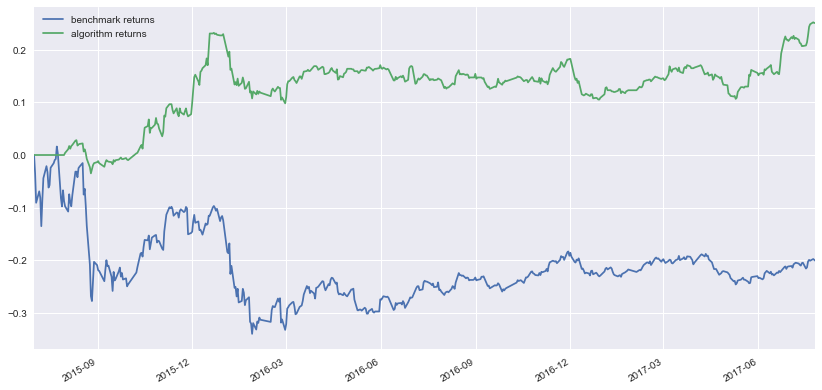

In [11]:
# A股中的沙盒symbol数据
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', 
                     '600036', '600809', '000002', '002594']
# 和上面类似，只是symbol_pool=cn_choice_symbols
stock_pickers = [{'class': AbuPickStockNTop,
                  'symbol_pool': cn_choice_symbols, 'n_top': 3, 'xd': 20}]
buy_factors = [{'class': AbuWeekMonthBuy, 'is_buy_month': True, 
                'stock_pickers': stock_pickers}]
abu_result_tuple = run_loo_back(cn_choice_symbols)

上面使用的择时策略AbuWeekMonthBuy本身是一个中性策略，没有明确的方向，即择时策略本身不属于趋势跟踪也不属于均值回复，通过搭配不同的选股策略才能明确择时策略本身的属性，如上例配合形成的趋势跟踪策略。

将上例AbuPickStockNTop选股策略中的direction_top=-1, AbuPickStockNTop选股策略中direction_top参数的意义为选取方向，默认为1，即选取涨幅最高的n_top个股票，传递-1即选取跌幅最高的n_top个股票，这样搭配上AbuWeekMonthBuy最终生效的策略将变成一个均值回复策略，买入上一个月**跌幅**最高的top支股票，每一个月进行一次买入操作, 持有一个月后卖出，如下所示：

In [12]:
stock_pickers = [{'class': AbuPickStockNTop,
                  'symbol_pool': cn_choice_symbols, 'n_top': 3, 
                  'direction_top': -1, 'xd': 20}]
buy_factors = [{'class': AbuWeekMonthBuy, 'is_buy_month': True, 
                'stock_pickers': stock_pickers}]
abu_result_tuple = run_loo_back(cn_choice_symbols, only_info=True)

买入后卖出的交易数量:70
买入后尚未卖出的交易数量:3
胜率:58.5714%
平均获利期望:8.1669%
平均亏损期望:-9.8265%
盈亏比:1.1568
所有交易收益比例和:0.4988 
所有交易总盈亏和:193042.0000 


### 3. 进一步制造非均衡，提高交易概率优势

上面示例了中性择时策略配合选股策略分别形成趋势跟踪与均值回复策略，下面将示例通过选股策略配合原本带属性的择时策略，进一步在整个策略中制造非均衡，提高交易概率优势

下面在上一节使用的AbuFactorBuyWD的基础上配合使用AbuPickStockNTop做为选股策略，AbuFactorBuyWD的择时策略为

1. 默认以40天为周期(8周)结合涨跌阀值计算周几适合买入
2. 回测运行中每一个月重新计算一次上述的周几适合买入
3. 在策略日任务中买入信号为：昨天下跌，今天开盘也下跌，且明天是计算出来的上涨概率大的'周几'

下面构建AbuPickStockNTop时也以xd=40天为一个周期，计算周期内跌幅最大的3个股票，即整个策略在上面3条择时策略的基础上又添加了一条如下：

#### 4. 每一个月计算一次上两个月(xd=40)中跌幅最大的3支股票做为交易目标

实现如下所示：

In [13]:
"""
    xd=40: 为匹配择时策略AbuFactorBuyWD中的默认周期
    direction_top=-1: 选取跌幅最高的n_top
"""
stock_pickers = [{'class': AbuPickStockNTop,
                  'symbol_pool': us_choice_symbols, 'n_top': 3, 
                  'direction_top': -1, 'xd': 40}]
"""
    买入因子AbuFactorBuyWD参数stock_pickers做为买入因子的专属选股因子进行动态选股
"""
buy_factors = [{'class': AbuFactorBuyWD, 'stock_pickers': stock_pickers}]
# 卖出策略使用AbuFactorSellNDay，sell_n=1即只持有一天
sell_factors = [{'class': AbuFactorSellNDay, 'sell_n': 1, 'is_sell_today': True}]
abu_result_tuple = run_loo_back(us_choice_symbols, 
                                start='2013-07-26', end='2016-07-26', only_info=True)

买入后卖出的交易数量:48
买入后尚未卖出的交易数量:0
胜率:54.1667%
平均获利期望:1.8156%
平均亏损期望:-1.7863%
盈亏比:1.4292
所有交易收益比例和:0.0791 
所有交易总盈亏和:56785.2700 


回测结果上所示，下面使用上一节不使用选股策略进行配合的回测进行对比，如下：

In [14]:
buy_factors = [{'class': AbuFactorBuyWD}]
sell_factors = [{'class': AbuFactorSellNDay, 'sell_n': 1, 'is_sell_today': True}]
abu_result_tuple = run_loo_back(us_choice_symbols, 
                                start='2013-07-26', end='2016-07-26', only_info=True)

买入后卖出的交易数量:146
买入后尚未卖出的交易数量:2
胜率:53.4247%
平均获利期望:1.9614%
平均亏损期望:-1.9299%
盈亏比:1.1535
所有交易收益比例和:0.2369 
所有交易总盈亏和:74038.9600 


对比可以发现使用AbuPickStockNTop选股策略与均值回复的择时策略AbuFactorBuyWD进行配合，更进一步**制造非均衡交易环境**，提高交易概率优势的回测比上一节的回测结果要好一些，但交易数量下降了接近60%，因为择时策略＋选股策略配合形成了一个更加**苛刻**的均值回复策略，量化分析的最大长处即是通过计算机强大的运算能力，在广度上占有绝对优势，即如果是传统人脑的分析方式上述方法是行不通的，因为人的能力范围内所能涉及的交易目标数量有限，上述苛刻条件可能导致交易者很长时间无交易可做，但通过量化交易可以在短时间内完成对不同市场的不同交易目标分析，达到理想的交易数量。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)